In [1]:
import json
import os
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from tqdm import tqdm

In [3]:
df = pd.read_csv('Phoenix_reviews.csv')

In [4]:
df = df.drop(['Unnamed: 0'], axis=1)
df

,name,business_id,city,categories,review_id,text,stars,user_id
0,Wetzel's Pretzels,vjTVxnsQEZ34XjYNS-XUpA,Phoenix,"Food, Pretzels, Bakeries, Fast Food, Restaurants",LyxX4jQXCj6p7ood9Y_ung,Love Wetzel's pretzels! I always get them when...,5.0,7C4B2Skmh4X9f8xJDo9O4w
1,Wetzel's Pretzels,vjTVxnsQEZ34XjYNS-XUpA,Phoenix,"Food, Pretzels, Bakeries, Fast Food, Restaurants",WqQkmdfkcvQZNGpI6Xzfow,Wetzels's Pretzels is definitely amazing and v...,5.0,eavBO3KRzBf8sM6KGa_-NQ
2,Wetzel's Pretzels,vjTVxnsQEZ34XjYNS-XUpA,Phoenix,"Food, Pretzels, Bakeries, Fast Food, Restaurants",lJsEaUqx_iS-IsPD3SHWlg,I love Wetzel's Pretzels. And I can't imagine ...,5.0,sYQyXDjGaJj7wfaqz5u8KQ
3,Wetzel's Pretzels,vjTVxnsQEZ34XjYNS-XUpA,Phoenix,"Food, Pretzels, Bakeries, Fast Food, Restaurants",PfyDflR_hCtMsqR19KkNsg,"Never heard of the cheese meltdown pretzel, bu...",4.0,ELcQDlf69kb-ihJfxZyL0A
4,Wetzel's Pretzels,vjTVxnsQEZ34XjYNS-XUpA,Phoenix,"Food, Pretzels, Bakeries, Fast Food, Restaurants",RcsBd87ZxdI6h9A-E80X1A,"PV Mall's food court needs updating, but that ...",4.0,y9yLaWKlT2aXLBs50FGvaw
...,...,...,...,...,...,...,...,...
510977,Hooters,YZeUH6zYS0dq5QHLYZhUnQ,Phoenix,"Nightlife, American (Traditional), Chicken Win...",UHxh8cceuZ1epEsoaMqG_w,Only reason I'm rating a 1 star is because I o...,1.0,4nLvVz0SQ3SoW-IDROOl2g
510978,Hooters,YZeUH6zYS0dq5QHLYZhUnQ,Phoenix,"Nightlife, American (Traditional), Chicken Win...",3ycxbjfTL-cPq_Fj0SxhyQ,Always good customer service if nikkei is work...,5.0,G6U4pyPsg3rkcIZBE0HGpw
510979,Hooters,YZeUH6zYS0dq5QHLYZhUnQ,Phoenix,"Nightlife, American (Traditional), Chicken Win...",Lv86RrB9wZxq7LFbo8mokQ,"I hate to give a one star, but this place need...",1.0,zY4RR6kG0AgioqbgpXCsFg
510980,Hooters,YZeUH6zYS0dq5QHLYZhUnQ,Phoenix,"Nightlife, American (Traditional), Chicken Win...",6BA1Y6t4PIPg7RQthc6v8w,I LOVE HOOTERS! When I came to this particular...,1.0,Tc4lyLReAvMm0Q3uzuSY7Q


In [5]:
df2 = df[['name', 'stars', 'user_id']]
df2

,name,stars,user_id
0,Wetzel's Pretzels,5.0,7C4B2Skmh4X9f8xJDo9O4w
1,Wetzel's Pretzels,5.0,eavBO3KRzBf8sM6KGa_-NQ
2,Wetzel's Pretzels,5.0,sYQyXDjGaJj7wfaqz5u8KQ
3,Wetzel's Pretzels,4.0,ELcQDlf69kb-ihJfxZyL0A
4,Wetzel's Pretzels,4.0,y9yLaWKlT2aXLBs50FGvaw
...,...,...,...
510977,Hooters,1.0,4nLvVz0SQ3SoW-IDROOl2g
510978,Hooters,5.0,G6U4pyPsg3rkcIZBE0HGpw
510979,Hooters,1.0,zY4RR6kG0AgioqbgpXCsFg
510980,Hooters,1.0,Tc4lyLReAvMm0Q3uzuSY7Q


In [6]:
split = int(len(df2) * 0.80)
train_data = df2[:split]
test_data = df2[split:]

<ipython-input-7-f5ab50eed8f5>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([num for num in ax.get_yticks()])


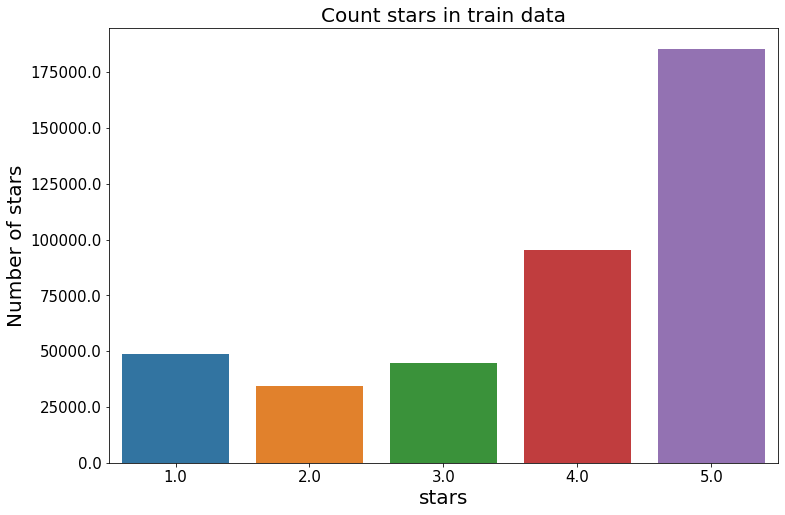

In [7]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="stars", data=train_data)
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Count stars in train data", fontsize = 20)
plt.xlabel("stars", fontsize = 20)
plt.ylabel("Number of stars", fontsize = 20)
plt.show()

In [11]:
num_rev_per_user = train_data.groupby(by = 'user_id')['stars'].count().sort_values(ascending = False)
users_over_50_revs = list(num_rev_per_user[num_rev_per_user > 50].index)

In [18]:
filtered1 = train_data[train_data['user_id'].isin(users_over_50_revs)]
filtered1

,name,stars,user_id
0,Wetzel's Pretzels,5.0,7C4B2Skmh4X9f8xJDo9O4w
2,Wetzel's Pretzels,5.0,sYQyXDjGaJj7wfaqz5u8KQ
3,Wetzel's Pretzels,4.0,ELcQDlf69kb-ihJfxZyL0A
6,Wetzel's Pretzels,5.0,S0YQ47x5g8SfZe87KGvsJw
9,Wetzel's Pretzels,4.0,A0j21z2Q1HGic7jW6e9h7A
...,...,...,...
408677,Bobby Q,5.0,KGsXnYHvYddGaL_jyl0DMQ
408707,Bobby Q,4.0,wcDhhBk1d0_lCdvB8sds1g
408760,Bobby Q,5.0,kd9--kcOScxGYuDbW9wOBQ
408766,Bobby Q,4.0,niKu4se6xtf-ctlm0udr1w


In [16]:
num_rev_per_restaurant = train_data.groupby(by = 'name')["stars"].count().sort_values(ascending = False)
places_over_50_revs = list(num_rev_per_restaurant[num_rev_per_restaurant > 50].index)
places_over_50_revs

["Matt's Big Breakfast",
 'Pizzeria Bianco',
 'The Arrogant Butcher',
 'Little Miss BBQ',
 'Lux Central',
 "Lo-Lo's Chicken & Waffles",
 'Cibo',
 'Chino Bandido',
 "McDonald's",
 'Original Breakfast House',
 'Angry Crab Shack',
 'St. Francis Restaurant',
 'Los Taquitos',
 'FEZ',
 'Barrio Café',
 'The Henry',
 "Spinato's Pizzeria",
 'Pita Jungle',
 'Bobby Q',
 'The Parlor',
 'La Grande Orange',
 'Harumi Sushi',
 'Postino Arcadia',
 "Hula's Modern Tiki",
 'True Food Kitchen',
 'OHSO Brewery- Arcadia',
 'Windsor',
 "Lou Malnati's Pizzeria",
 'The Clever Koi',
 'Steak 44',
 "Rustler's Rooste",
 'Joyride Taco House',
 'Flower Child',
 'Gallo Blanco',
 'Chipotle Mexican Grill',
 'Angels Trumpet Ale House',
 'Blanco Tacos + Tequila',
 'IHOP',
 'Cherryblossom Noodle Cafe',
 'Phoenix Public Market Cafe',
 'Cocina Madrigal',
 'Gadzooks Enchiladas and Soup',
 'Zinburger',
 'Welcome Diner',
 'Vovomeena',
 'Ocotillo',
 'First Watch',
 'Humble Pie',
 'The Stand',
 'Federal Pizza',
 "Durant's",
 "Dic

In [17]:
filtered2 = filtered1[filtered1['name'].isin(places_over_50_revs)]
filtered2

,name,stars,user_id
18,Church's Chicken,4.0,tCbEkK11lnqeaNVkhlurrQ
104,Bonus Round,5.0,8Aj0YKThtXkSuauONIzYfQ
107,Bonus Round,3.0,sTcYq6goD1Fa2WS9MSkSvQ
108,Bonus Round,4.0,HPuywU9mgUcRwf7W-yYz-w
148,Bonus Round,4.0,d_TBs6J3twMy9GChqUEXkg
...,...,...,...
408677,Bobby Q,5.0,KGsXnYHvYddGaL_jyl0DMQ
408707,Bobby Q,4.0,wcDhhBk1d0_lCdvB8sds1g
408760,Bobby Q,5.0,kd9--kcOScxGYuDbW9wOBQ
408766,Bobby Q,4.0,niKu4se6xtf-ctlm0udr1w


In [23]:
test = filtered2.pivot_table(index='user_id', columns='name', values='stars').fillna(0)

In [24]:
test

name,#1 Sushi,1130 The Restaurant,16th Street Sports Bar & Grill,24th Street Pizza & Gyros,25 Degrees,2601 on Central,3on Smith Cafe,40th Street Cafe,5 & Diner,ATL Wings,...,Zipps Sports Grill,Zoes Kitchen,Zookz Sandwiches,Zoyo Frozen Yogurt - Downtown Phoenix,la Madeleine French Bakery & Cafe,noca,stonegrill,zpizza,zpizza - Phoenix Midtown,Überrito
user_id,,,,,,,,,,,,,,,,,,,,,
-0udWcFQEt2M8kM3xcIofw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-RhRXVW9z9fs5zzxhFfnHg,0.0,3.5,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
-eBkx1Hl2A40GZAaZvXR1Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-fQPzH-e-ubDIiLQhybEjQ,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-guyVbrMJxVeBcfdRQc6xw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
z5TgzjEw8YfEbD4KkgKRxw,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zSwb7qNpSgU3ekHMpiHsOA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
zTK1nPD2Hpa-ksSXsE-JzQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
def similarity_pearson(x, y):
    import scipy.stats
    return scipy.stats.pearsonr(x, y)[0]

In [30]:
similarity_matrix = np.array([similarity_pearson(test.iloc[i,:], test.iloc[j,:])
                             for i in range(0, 377) for j in range(0, 377)])
similarity_df = pd.DataFrame(data=similarity_matrix.reshape(377, 377))
similarity_df

,0,1,2,3,4,5,6,7,8,9,...,367,368,369,370,371,372,373,374,375,376
0,1.000000,0.009116,0.026925,-0.015581,0.006168,0.095330,-0.011761,-0.014566,0.050640,0.028552,...,0.022234,-0.015081,0.040809,0.016311,0.023571,-0.032692,0.011882,0.090455,0.021327,0.008585
1,0.009116,1.000000,0.182427,0.207147,0.005202,0.048587,0.148123,0.183861,0.071489,0.109535,...,0.132520,0.012821,0.055778,0.021850,0.021634,0.044659,0.135997,0.109143,0.006493,-0.018581
2,0.026925,0.182427,1.000000,0.137099,-0.013183,0.042256,0.044996,0.172670,0.082500,0.092254,...,0.006722,0.042015,0.078352,0.001139,0.016480,0.045166,0.181819,0.183422,-0.019653,-0.039733
3,-0.015581,0.207147,0.137099,1.000000,-0.013268,0.037407,0.147681,0.126652,0.005970,0.074535,...,0.049699,0.027155,0.123803,0.004886,0.024904,0.046877,0.208332,0.076905,-0.019004,-0.019901
4,0.006168,0.005202,-0.013183,-0.013268,1.000000,0.002604,0.091241,0.017778,-0.039403,0.084520,...,0.035157,0.018276,0.030779,-0.000684,0.052614,-0.010579,0.104999,-0.045573,0.009672,0.150493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,-0.032692,0.044659,0.045166,0.046877,-0.010579,-0.021420,-0.003443,0.020536,-0.015715,0.022235,...,0.054039,0.078026,0.029688,0.182024,0.006776,1.000000,0.017687,-0.048768,0.054667,-0.034720
373,0.011882,0.135997,0.181819,0.208332,0.104999,0.046960,0.095486,0.239106,-0.010422,0.171405,...,0.020584,-0.004211,0.090424,0.013862,0.080468,0.017687,1.000000,0.160998,0.009076,0.002821
374,0.090455,0.109143,0.183422,0.076905,-0.045573,0.101879,-0.017888,0.128696,0.097107,0.119195,...,0.057230,-0.004034,0.040454,-0.020761,0.002908,-0.048768,0.160998,1.000000,-0.013149,0.012100
375,0.021327,0.006493,-0.019653,-0.019004,0.009672,0.030214,0.017593,-0.015772,-0.038849,0.062125,...,-0.045872,-0.004296,0.033831,0.170320,-0.024464,0.054667,0.009076,-0.013149,1.000000,0.102931


In [32]:
similarity_df[1].sort_values()

133   -0.044751
286   -0.034798
189   -0.029515
129   -0.028302
125   -0.027425
         ...   
207    0.350967
271    0.354528
39     0.372630
217    0.781294
1      1.000000
Name: 1, Length: 377, dtype: float64

In [35]:
test.iloc[[1, 217]]

name,#1 Sushi,1130 The Restaurant,16th Street Sports Bar & Grill,24th Street Pizza & Gyros,25 Degrees,2601 on Central,3on Smith Cafe,40th Street Cafe,5 & Diner,ATL Wings,...,Zipps Sports Grill,Zoes Kitchen,Zookz Sandwiches,Zoyo Frozen Yogurt - Downtown Phoenix,la Madeleine French Bakery & Cafe,noca,stonegrill,zpizza,zpizza - Phoenix Midtown,Überrito
user_id,,,,,,,,,,,,,,,,,,,,,
-RhRXVW9z9fs5zzxhFfnHg,0.0,3.5,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
XNSyl47aXuPsvC5zXm5uhw,0.0,3.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0


City/Query Function

In [13]:
def filterer(query, city, user_id):
    data = {"business_id":[],"stars":[], "user_id":[]}
    with open('yelp_academic_dataset_review.json', encoding='utf-8') as f:   
        for line in tqdm(f):
            review = json.loads(line)
            data['business_id'].append(review['business_id'])
            data['stars'].append(review['stars'])
            data['user_id'].append(review['user_id'])
    df = pd.DataFrame(data)
    data1 = {"name":[],"business_id":[],"city":[],"categories":[]}
    with open('yelp_academic_dataset_business.json', encoding='utf-8') as f:
        for line in tqdm(f):
            business = json.loads(line)
            data1['name'].append(business['name'])
            data1['business_id'].append(business['business_id'])
            data1['city'].append(business['city'])
            data1['categories'].append(business['categories'])
    df1 = pd.DataFrame(data1)
    df.dropna(inplace=True)
    df1.dropna(inplace=True)
    restaurants_business = df1[(df1.categories.str.contains("Restaurants")) & (df1.categories.str.contains(query))]
    city_rest = restaurants_business[restaurants_business.city == city]
    finaldf = city_rest.merge(df,on="business_id",how="inner")
    finaldf['num_reviews'] = 1
    best_list = finaldf.groupby(['name', 'business_id','categories']).agg({'stars': 'mean', 'num_reviews':'sum'}).reset_index()
    #final_reviews = finaldf[finaldf.name==resname]
    #review = final_reviews.reset_index().text
    #data = pd.DataFrame(review)
    if user_id != None:
        return best_list, df[df['user_id'] == user_id]
    return best_list#data1,data

In [14]:
best, user_df = filterer("Chicken", "Las Vegas", "OwjRMXRC0KyPrIlcjaXeFQ")

8021122it [01:04, 123830.60it/s]
209393it [00:02, 90135.86it/s]


In [15]:
user_df

,business_id,stars,user_id
0,-MhfebM0QIsKt87iDN-FNw,2.0,OwjRMXRC0KyPrIlcjaXeFQ
5638837,9SU7ZZhaFUJJ6m2k5HKHeg,1.0,OwjRMXRC0KyPrIlcjaXeFQ


In [25]:
best['stars'].mean()

3.2020503287439075

In [5]:
best.sort_values(by=['num_reviews'], ascending=False)

,name,business_id,categories,stars,num_reviews
28,Bruxie,0d0i0FaJq1GIeW1rS2D-5w,"Desserts, Food, Restaurants, Breakfast & Brunc...",4.411955,1857
109,Hooters Casino Hotel Las Vegas,4GXII-GU7S0ZyU6ElkhscQ,"Adult Entertainment, Sports Bars, Bars, Nightl...",2.343590,1365
150,Lo-Lo's Chicken and Waffles,z5J9U_HU4iVLwaCH6rdC2w,"Soul Food, Restaurants, Chicken Shop, Breakfas...",3.199398,1329
18,Black Tap - Las Vegas,TmIucPRTngutrjDpC0nXgQ,"Restaurants, Bars, Burgers, Ice Cream & Frozen...",3.997070,1024
35,Buldogis Gourmet Hot Dogs,WRQ-9LluyivReFiQZFUujw,"Chicken Wings, Korean, Asian Fusion, Hot Dogs,...",4.391837,980
...,...,...,...,...,...
277,"Scotty""s Kitchen",QW0YuA4bhfGjnhNWwiYWsw,"Nightlife, Barbeque, Pubs, American (Tradition...",5.000000,3
157,Meat Chix And Wieners,GxQGCl4hX6nbRdSYH9egEw,"Restaurants, Burgers, American (Traditional), ...",3.666667,3
255,Quickee Burgers,Zrtozs1rdJREGNxFRTcV3Q,"Juice Bars & Smoothies, Fast Food, Food, Ameri...",2.333333,3
205,Pizza Hut,X0RNJ8BTjMUEKsIXekQp_g,"Restaurants, Pizza, Chicken Wings, Italian",2.333333,3
